In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import NearestNeighbors

from sklearn.metrics import classification_report

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
### Load the training array, labels and features
train_array = np.load('train_array.npy')
train_labels = np.load('train_labels.npy')
train_features = np.load('train_features.npy')

In [3]:
### Load the validation array, labels and features
valid_array = np.load('valid_array.npy')
valid_labels = np.load('valid_labels.npy')
valid_features = np.load('valid_features.npy')

In [4]:
### Load the test array, labels and features
test_array = np.load('test_array.npy')
test_labels = np.load('test_labels.npy')
test_features = np.load('test_features.npy')

# Prepocess the data

In [5]:
### Define a pipeline with normalizer
pipe = Pipeline([
    ('scaler', StandardScaler()),
])

pipe.fit(train_features)

processed_train_features = pipe.transform(train_features)
processed_valid_features = pipe.transform(valid_features)
processed_test_features = pipe.transform(test_features)

In [6]:
### Create inputs and outputs for training ang validation
X_train = processed_train_features
X_valid = processed_valid_features
X_test = processed_test_features
y_train = train_labels
y_valid = valid_labels
y_test = test_labels

# kNN Classifier
Fit and tune a k-NN classifier. Visualize the train and validation curvesset

To tune the hyperparameters of the KNN, different splits have been done on the features.  
The features have been splitted in 8 groups, initially, tuned and then halving the groups, adjusting the tuning parameters, tuning again and so on, till reaching one single group.

In [7]:
x = int(280)
for i in range(1):
    knn_model = KNeighborsClassifier()
    
    params = {
        'n_neighbors': [2, 3, 4, 5, 6],
        'weights': ['uniform', 'distance'],
        'leaf_size': [1, 2],
        'p': [1, 2],
        'metric': ['minkowski'],
    }
    
    grid_model = GridSearchCV(estimator=knn_model, param_grid=params, cv=5, scoring='accuracy', return_train_score=True)
    grid_model.fit(X_train[i*x:(i+1)*x], y_train[i*x:(i+1)*x])
    ### Print the best accuracy
    print(f'\n Score and parameters from the feature number {i*x} to the feature number {(i+1)*x}')
    print(grid_model.best_score_)
    ### Print the best parameters
    print(grid_model.best_params_)


 Score and parameters from the feature number 0 to the feature number 280
0.8857142857142858
{'leaf_size': 1, 'metric': 'minkowski', 'n_neighbors': 6, 'p': 1, 'weights': 'distance'}


In [8]:
print('Best paramemeters',grid_model.best_params_) 
print('Best training score:{:.2f}'.format(grid_model.score(X_train, y_train)))
print('Best validation score:{:.2f}'.format(grid_model.best_score_))
print('Best test score:{:.2f}'.format(grid_model.score(X_valid, y_valid)))

Best paramemeters {'leaf_size': 1, 'metric': 'minkowski', 'n_neighbors': 6, 'p': 1, 'weights': 'distance'}
Best training score:1.00
Best validation score:0.89
Best test score:0.87


In [9]:
print('Best test score:{:.2f}'.format(grid_model.score(X_test, y_test)))

Best test score:0.96


In [10]:
### Define the model with the best parameters
knn_best = grid_model.best_estimator_

# Classification report
Provide a classification report and visualize the confusion matrix of the test dataset

In [11]:
knn_best.fit(X_train, y_train)

# Classification report
y_preds = knn_best.predict(X_valid)
print(classification_report(y_valid, y_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       0.91      0.94      0.92        32
           2       0.96      1.00      0.98        25
           3       0.83      0.31      0.45        16
           4       0.69      0.95      0.80        21
           5       0.67      0.67      0.67        12

    accuracy                           0.87       139
   macro avg       0.84      0.81      0.80       139
weighted avg       0.88      0.87      0.86       139



The recall for **type 3** is 0.31, which is not good. This means that, in the 31% of the time the model predict **type 3** when it is, and the precision is 0.83, which means that the model is correct at 83% when predict **type 3**.  

In [12]:
# Compute probabilities
y_probs = knn_best.predict_proba(X_valid)
print("Predictions:", y_preds[:5])
print("Probs:")
print(y_probs[:5])

Predictions: [0 0 0 0 0]
Probs:
[[0.83606383 0.         0.         0.16393617 0.         0.        ]
 [1.         0.         0.         0.         0.         0.        ]
 [1.         0.         0.         0.         0.         0.        ]
 [1.         0.         0.         0.         0.         0.        ]
 [1.         0.         0.         0.         0.         0.        ]]


# Correct classification
Pick an image which was correctly classified in the test set and plot its 10 nearest neighbors from the training set. An example is depicted below

In [13]:
knearest = NearestNeighbors(n_neighbors=10)
knearest.fit(X_train)
### Set the distance and the index
near_dist, near_idx = knearest.kneighbors(test_features[0].reshape(1, -1), return_distance=True)

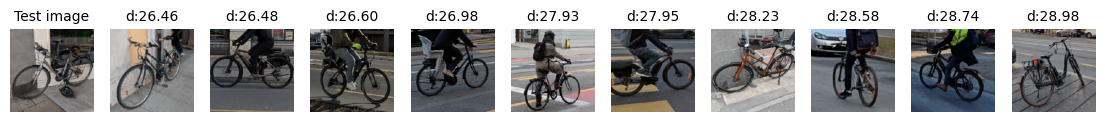

In [14]:
fig, axs = plt.subplots(1, 11)
fig.set_figwidth(14)
fig.set_figheight(3)
axs[0].imshow(test_array[0])
axs[0].axis('off')
axs[0].set_title('Test image', fontsize=10)
for i in range(len(near_idx[0])):
    axs[i+1].imshow(train_array[near_idx[0][i]])
    axs[i+1].axis('off')
    axs[i+1].set_title('d:{:.2f}'.format(near_dist[0][i]), fontsize=10)

All the images are correctly classified

# Misclassification
Pick an image which was misclassified in the test set and plot its 10 neighbors from the training set

True label: 5
Pred label: 1


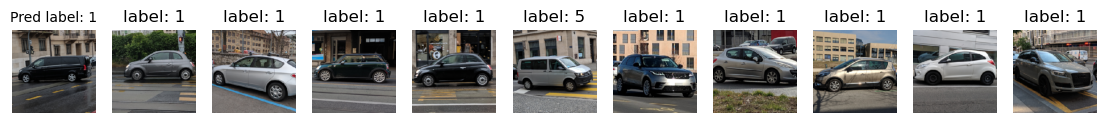

In [15]:
### Let's repeat the previous method
y_test_preds = knn_best.predict(X_test)
knearest = NearestNeighbors(n_neighbors=10)
knearest.fit(X_train)
idx = np.abs(y_test_preds - y_test).argmax()
near_dist, near_idx = knearest.kneighbors(X_test[idx].reshape(1, -1), return_distance=True)
print(f'True label: {y_test[idx]}')
print(f'Pred label: {y_test_preds[idx]}')

fig, axs = plt.subplots(1, 11)
fig.set_figwidth(14)
fig.set_figheight(3)
axs[0].imshow(test_array[idx])
axs[0].axis('off')
# axs[0].set_title('Test image', fontsize=10)
axs[0].set_title(f'Pred label: {y_test_preds[idx]}', fontsize=10)
for i in range(len(near_idx[0])):
    axs[i+1].imshow(train_array[near_idx[0][i]])
    axs[i+1].axis('off')
    # axs[i+1].set_title('d:{:.2f}'.format(near_dist[0][i]), fontsize=10)
    axs[i+1].set_title(f'label: {y_train[near_idx[0][i]]}')